## IMPORTS

In [1]:
using Random,LinearAlgebra, Flux.Optimise, Plots, ForneyLab
using ForneyLab: iBLR,renderCVI_test_F
using Statistics:median

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
  ** incremental compilation may be fatally broken for this module **



In [2]:
Random.seed!(1234);

## Algorithm Params

In [3]:
μ_out = 3.0
s_out = 5000.0
msg_out = Message(Univariate, GaussianWeightedMeanPrecision,xi=s_out*μ_out,w=s_out)

Message: 𝒩(xi=1.50e+04, w=5.00e+03)


In [4]:
μ_in = 0.0
s_in = 0.01
msg_in = Message(Univariate, GaussianWeightedMeanPrecision,xi=s_in*μ_in,w=s_in)

Message: 𝒩(xi=0.00, w=1.00e-02)


In [5]:
f(x) = x
logp_nc(z) = logPdf(msg_out.dist, f(z))
opt = iBLR(0.9)
num_iterations = 1000
λ_init = [s_in*μ_in,-0.5*s_in] # Natparams

2-element Array{Float64,1}:
  0.0
 -0.005

## iBLR with Free Energy

In [6]:
(λ,F) = renderCVI_test_F(logp_nc,num_iterations,opt,λ_init,msg_in);
#λ: Array of BCN parameters [μ,S] over iterations
#F: Free energy array with corresponding λ over iterations

## Processing FE

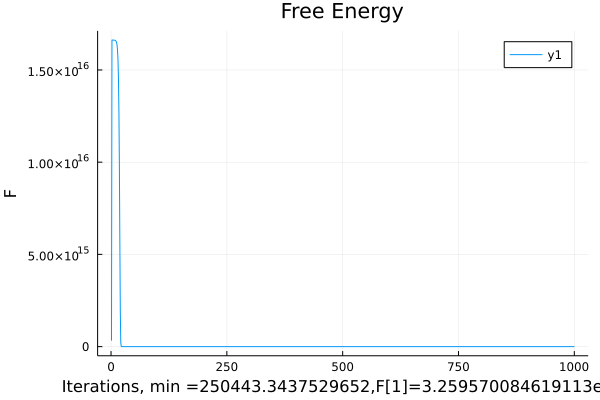

In [7]:
plot(F[1:end])
plot!(title = "Free Energy", xlabel = "Iterations, min =$(minimum(F)),F[1]=$(F[1])", ylabel = "F")

In [8]:
idx_max = argmax(F)
idx_min = argmin(F)
println("Min idx = $idx_min, Min F params λ=$(λ[idx_min]),F_min = $(F[idx_min])")
println("Last λ params=$(λ[end]),F = $(F[end])")

Min idx = 957, Min F params λ=[2.9642626806233463, 5000.01],F_min = 250443.3437529652
Last λ params=[3.000628824252756, 5000.01],F = 250453.74862242624


## ELBO (-FE) based Stopping Algorithm (STAN)

In [9]:
tolerance = 0.005
elbo_best = -Inf
elbo_prev = -Inf
d_elbo = Inf
d_elbo_ave = Inf
d_elbo_med = Inf

Inf

In [10]:
i_max = size(F)[1]
elbo_prev = -F[1]
elbo_best = -F[1]
# Arrays
elbo_reldif_vect = Vector{Float64}(undef,i_max-1)
elbo_reldif_mean_vect = Vector{Float64}(undef,i_max-1)
elbo_reldif_median_vect = Vector{Float64}(undef,i_max-1)
i_end = 0 # Algorithm stop index
i_best=  0
for i = 2:i_max
    elbo_now = -F[i] # F[t+1]
    if elbo_now < elbo_best 
        elbo_best = elbo_now
        i_best = i
    end
    d_elbo = abs(100*(elbo_now-elbo_prev)/elbo_prev) # Relative change percentage-wise abs((F[t+1] - F[t])/F[t])
    elbo_reldif_vect[i-1] = deepcopy(d_elbo) # 
    
    elbo_reldif_mean = mean(elbo_reldif_vect[1:i-1]) # Calculate mean
    elbo_reldif_median = median(elbo_reldif_vect[1:i-1]) # Calculate median
    
    
    elbo_reldif_mean_vect[i-1] = deepcopy(elbo_reldif_mean)
    elbo_reldif_median_vect[i-1] = deepcopy(elbo_reldif_median)
    
    if elbo_reldif_mean <tolerance # Compare mean with tolerance
        println("Mean converged , i = $i, min_i at i_min = $idx_min")
        i_end  =i
        break
    end
    if elbo_reldif_median <tolerance # Compare median with tolerance
        println("Median converged with value $elbo_reldif_median, i = $i, min_i at i_min = $idx_min")
        i_end  =i
        break
    end   
    # End Conditions
    elbo_prev = elbo_now
    if i == i_max # If algo does not converge in terms of mean and median, i_end is the max iteration value
        i_end = i_max
    end
end
# Print Results
if i_end < i_max
println("--------")
println("-ELBO calculated=$(F[1:i_end])")
println("ELBO relative differences=$(elbo_reldif_vect[1:i_end-1])")
println("Mean vector =$(elbo_reldif_mean_vect[1:i_end-1])")
println("Median vector =$(elbo_reldif_median_vect[1:i_end-1])")
end
println("--------")
println("λ=$(λ[i_end])")
println("λ_min=$(λ[idx_min])")
println("Absolute Difference from FE at λ_min = $(abs(F[i_end]-F[idx_min]))")
println("Relative % Difference from FE at λ_min = $(abs(100*(F[i_end]-F[idx_min])/F[idx_min]))")

Median converged with value 0.0018324367654331815, i = 4, min_i at i_min = 957
--------
-ELBO calculated=[3.259570084619113e14, 1.6621286506124008e16, 1.662112326762885e16, 1.6620818696055266e16]
ELBO relative differences=[4999.226607997979, 0.0009821050560548114, 0.0018324367654331815]
Mean vector =[4999.226607997979, 2499.6137950515176, 1666.409807513267]
Median vector =[4999.226607997979, 2499.6137950515176, 0.0018324367654331815]
--------
λ=[-2.552984100107861e6, 1.3039884192269637e8]
λ_min=[2.9642626806233463, 5000.01]
Absolute Difference from FE at λ_min = 1.6620818695804822e16
Relative % Difference from FE at λ_min = 6.636558371541083e12
